# Regression with discrete dependent variables

files needed = ('pntsprd.dta', 'apple.dta')

We continue to learn about the statsmodels package [(docs)](https://devdocs.io/statsmodels/), which provides functions for formulating and estimating statistical models. This notebook will not address the models, per se, but will focus on how to take what you learned in econometrics class and use it in python. 

In this notebook, we take on models in which the dependent variable is discrete. In the examples below, the dependent variable is binary (which makes it easier to visualize), but many of the techniques we demo here can be extended to other dependent variables.  

[Here](http://www.statsmodels.org/0.6.1/examples/notebooks/generated/discrete_choice_overview.html) is a nice overview of the discrete choice models in statsmodels. 

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import seaborn as sea                  # advanced plotting

import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

### Reading Stata data files

We will work on a problem from Wooldridge's textbook in econometrics. We read the (mercifully) cleaned data files using the pandas method `.read_stata()` that [reads stata files](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_stata.html). 

The file 'pntsprd.dta' contains data about Vegas betting. The complete variable list is [here](http://fmwww.bc.edu/ec-p/data/wooldridge/pntsprd.des). We will use `favwin` which is equal to 1 if the favored team won and zero otherwise and `spread` which holds the betting spread. In this context, a *spread* is the number of points that the favored team must beat the unfavored team by in order to be counted as a win by the favored team.    

In [2]:
# Use pandas read_stata method to get the stata formatted data file into a DataFrame.
vegas = pd.read_stata('pntsprd.dta')

# Take a look...so clean!
vegas.head()

,favscr,undscr,spread,favhome,neutral,fav25,und25,fregion,uregion,scrdiff,sprdcvr,favwin
0,72.0,61.0,7.0,0.0,0.0,1.0,0.0,3.0,4.0,11.0,1.0,1.0
1,82.0,74.0,7.0,1.0,0.0,0.0,0.0,3.0,1.0,8.0,1.0,1.0
2,87.0,57.0,17.0,1.0,0.0,0.0,0.0,3.0,3.0,30.0,1.0,1.0
3,69.0,70.0,9.0,1.0,0.0,0.0,0.0,3.0,3.0,-1.0,0.0,0.0
4,77.0,79.0,2.5,0.0,0.0,0.0,0.0,2.0,3.0,-2.0,0.0,0.0


In [3]:
vegas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   favscr   553 non-null    float32
 1   undscr   553 non-null    float32
 2   spread   553 non-null    float32
 3   favhome  553 non-null    float32
 4   neutral  553 non-null    float32
 5   fav25    553 non-null    float32
 6   und25    553 non-null    float32
 7   fregion  553 non-null    float32
 8   uregion  553 non-null    float32
 9   scrdiff  553 non-null    float32
 10  sprdcvr  553 non-null    float32
 11  favwin   553 non-null    float32
dtypes: float32(12)
memory usage: 26.1 KB


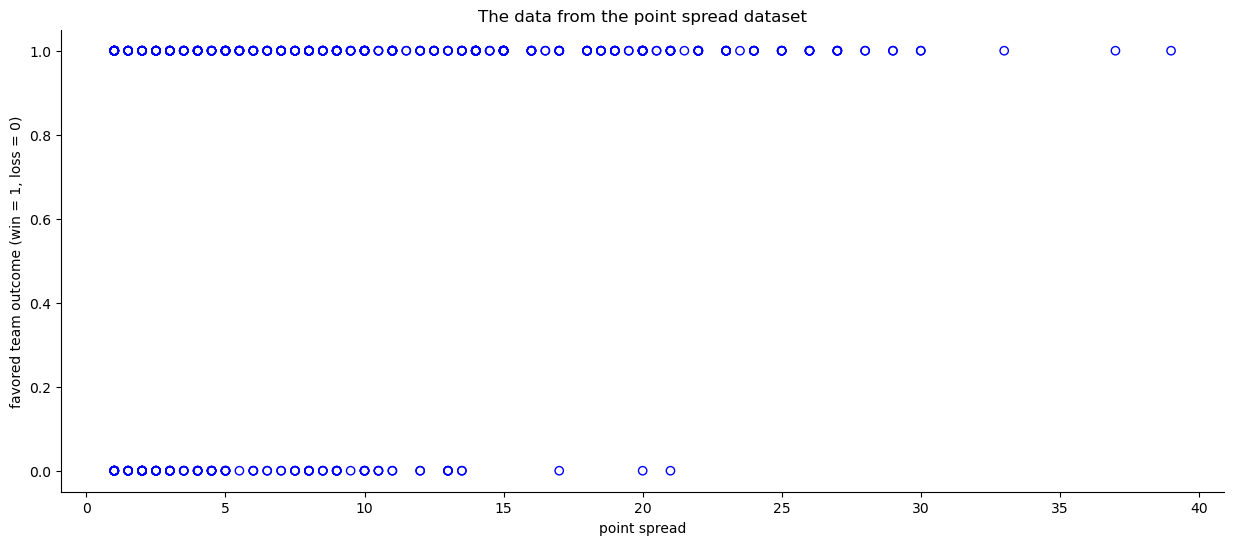

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(vegas['spread'], vegas['favwin'], 
           facecolors='none', edgecolors='blue')

ax.set_ylabel('favored team outcome (win = 1, loss = 0)')
ax.set_xlabel('point spread')
ax.set_title('The data from the point spread dataset')

sea.despine(ax=ax)

### OLS

We begin with the *linear probability model*. The model is 

$$\text{Pr}(favwin=1 \mid spread) = \beta_0 + \beta_1 spread + \epsilon .$$

There is nothing new here technique-wise. We are estimating this with ols.

In [5]:
# statsmodels adds a constant for us...
res_ols = smf.ols('favwin ~ spread', data=vegas).fit()

print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 favwin   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     68.57
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           9.32e-16
Time:                        08:45:35   Log-Likelihood:                -279.29
No. Observations:                 553   AIC:                             562.6
Df Residuals:                     551   BIC:                             571.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5769      0.028     20.434      0.0

Linear probability models have some problems. Perhaps the biggest one is that there is **no guarantee that the predicted probability lies between zero and one!** 

We can use the `fittedvalues` attribute of the results object to recover the fitted values of the y variables. Let's plot them and take a look. 

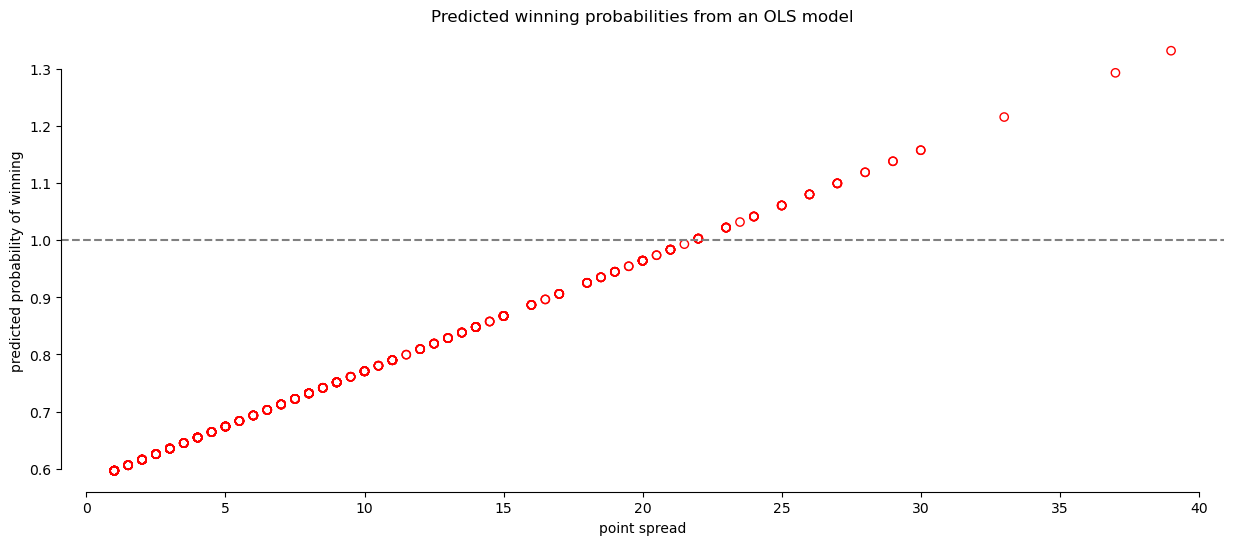

In [6]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(vegas['spread'], res_ols.fittedvalues,  facecolors='none', edgecolors='red')
ax.axhline(y=1.0, color='grey', linestyle='--')

ax.set_ylabel('predicted probability of winning')
ax.set_xlabel('point spread')
ax.set_title('Predicted winning probabilities from an OLS model')

sea.despine(ax=ax, trim=True)

### Logistic regression (logit)
The logistic regression passes the linear model through a non-linear function that constrains the output to lie between zero and one. (These functions are cumulative distribution functions.) In the logistic case, the function looks like

$$\text{prob} = \frac{\exp \left({\beta_0+\beta_1 spread}\right)}{1+\exp \left({\beta_0+\beta_1 spread}\right)},$$

and we predict a team wins whenever $\text{prob} \ge 0.5$.

We estimate the logit model with the `logit( )` method from `smf` in a way similar to ols. 

In [7]:
res_log = smf.logit('favwin ~ spread', data=vegas).fit()
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.477218
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 favwin   No. Observations:                  553
Model:                          Logit   Df Residuals:                      551
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                  0.1283
Time:                        08:52:13   Log-Likelihood:                -263.90
converged:                       True   LL-Null:                       -302.75
Covariance Type:            nonrobust   LLR p-value:                 1.201e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0712      0.173     -0.411      0.681      -0.411       0.268
spread         0.1632      0.

Interpreting logit coefficients is bit more complicated. The probability that a team wins is given by the expression

$$\text{prob} = \frac{\exp \left({\hat{\beta}_0+\hat{\beta}_1 spread}\right)}{1+\exp \left({\hat{\beta}_0+\hat{\beta}_1 spread}\right)}$$

The `res_log.fittedvalues` holds the fitted value of $\hat{\beta}_0+\hat{\beta}_1 spread$ and not the estimated probability. Let's compute it using the exp method of numpy. 


In [8]:
res_log.fittedvalues

0      1.071426
1      1.071426
2      2.703687
3      1.397878
4      0.336908
         ...   
548    0.336908
549    1.316265
550    2.214008
551    0.663360
552    0.418521
Length: 553, dtype: float64

In [9]:
pred_probs = np.exp(res_log.fittedvalues) / (1 + np.exp(res_log.fittedvalues))
pred_probs.describe()

count    553.000000
mean       0.763110
std        0.151419
min        0.523001
25%        0.622491
50%        0.774632
75%        0.901500
max        0.998157
dtype: float64

Plot the estimated probabilty of the favored team winning and the actual data. 

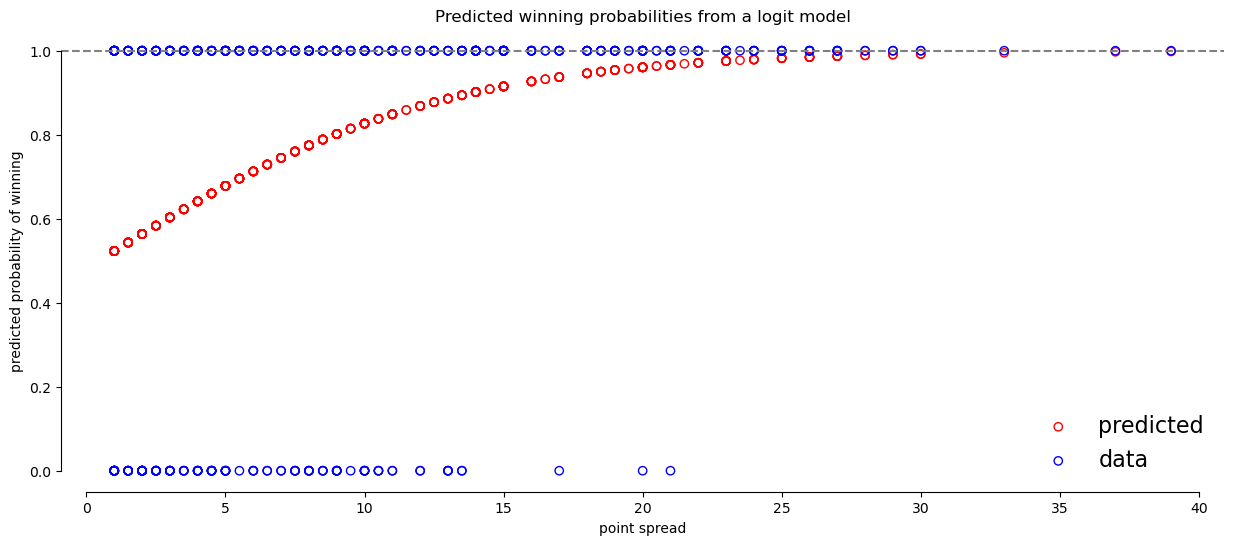

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(vegas['spread'], pred_probs,  facecolors='none', edgecolors='red', label='predicted')
ax.scatter(vegas['spread'], vegas['favwin'],  facecolors='none', edgecolors='blue', label = 'data')
ax.axhline(y=1.0, color='grey', linestyle='--')

ax.set_ylabel('predicted probability of winning')
ax.set_xlabel('point spread')
ax.set_title('Predicted winning probabilities from a logit model')

ax.legend(frameon=False, fontsize=16)
sea.despine(ax=ax, trim=True)

## Top Hat Practice Exercise

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. I am here, too.

1. Load the data 'apple.dta'. The data dictionary can be found [here](http://fmwww.bc.edu/ec-p/data/wooldridge/apple.des). The variable `ecolbs` is purchases of eco-friendly apples (whatever that means).  

2. Create a variable named `ecobuy` that is equal to 1 if the observation has a positive purchase of eco-apples (i.e., ecolbs>0). This will be our left-hand side variable. 

   Remember that 
```python 
apples['ecobuy'] = (apples['ecolbs']>0)
```

    Will create a variable of `True` and `False`. Then you can use `.astype(int)` to convert your True/False to zero/one.

In [13]:
apples = pd.read_stata('apple.dta')
apples.head()

,id,educ,date,state,regprc,ecoprc,inseason,hhsize,male,faminc,age,reglbs,ecolbs,numlt5,num5_17,num18_64,numgt64
0,10002,16,111597,SD,1.19,1.19,1,4,0,45,43,2.0,2.000000,0,1,3,0
1,10004,16,121897,KS,0.59,0.79,0,1,0,65,37,0.0,2.000000,0,0,1,0
2,10034,18,111097,MI,0.59,0.99,1,3,0,65,44,0.0,2.666667,0,2,1,0
3,10035,12,111597,TN,0.89,1.09,1,2,1,55,55,3.0,0.000000,0,0,2,0
4,10039,15,122997,NY,0.89,1.09,0,1,1,25,22,0.0,3.000000,0,0,1,0


In [24]:
apples['ecobuy'] = (apples['ecolbs']>0)
apples['ecobuy'] = apples['ecobuy'].astype(int)
apples.ecobuy.value_counts()

ecobuy
1    412
0    248
Name: count, dtype: int64

3. Estimate a linear probability model relating the probability of purchasing eco-apples to household characteristics. 

$$\text{ecobuy} = \beta_0 + \beta_1 \text{ecoprc} + \beta_2 \text{regprc} + \beta_3 \text{faminc} + \beta_4 \text{hhsize} + \beta_5 \text{educ} + \beta_6 \text{age} +  \epsilon$$

In [25]:
res_ols = smf.ols('ecobuy ~ regprc+ecoprc+faminc+hhsize+educ+age', data=apples).fit()

print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 ecobuy   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     13.43
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           2.18e-14
Time:                        09:04:56   Log-Likelihood:                -419.60
No. Observations:                 660   AIC:                             853.2
Df Residuals:                     653   BIC:                             884.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4237      0.165      2.568      0.0

4. How many estimated probabilities are negative? Are greater than one?

In [26]:
fitted = res_ols.fittedvalues
fitted.describe()

count    660.000000
mean       0.624242
std        0.160623
min        0.240317
25%        0.487370
50%        0.627557
75%        0.754041
max        1.070860
dtype: float64

5. Now estimate the model as a probit. A probit is similar to a logit in that we are passing the linear model through a nonlinear function. In this case, the nonlinear function is the cumulative density function of the normal distribution. 

$$\text{Pr}(\text{ecobuy}=1 \mid X) = \Phi \left(\beta_0 + \beta_1 \text{ecoprc} + \beta_2 \text{regprc} + \beta_3 \text{faminc} + \beta_4 \text{hhsize} + \beta_5 \text{educ} + \beta_6 \text{age} \right),$$

where $\Phi( )$ is the CDF of the normal distribution. Try `smf.probit()`.

In [32]:
res_prob = smf.probit('ecobuy ~ regprc+ecoprc+faminc+hhsize+educ+age', data=apples).fit()
print(res_prob.summary())

Optimization terminated successfully.
         Current function value: 0.604599
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                 ecobuy   No. Observations:                  660
Model:                         Probit   Df Residuals:                      653
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                 0.08664
Time:                        09:08:06   Log-Likelihood:                -399.04
converged:                       True   LL-Null:                       -436.89
Covariance Type:            nonrobust   LLR p-value:                 2.751e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2438      0.474     -0.514      0.607      -1.173       0.685
regprc         2.0302      0.

6. Compute the **marginal effects** of the coefficients at **the means** and print them out using `summary()`. You can get the marginal effects from the results object using `.get_margeff(at='mean')`  [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.ProbitResults.get_margeff.html#statsmodels.discrete.discrete_model.ProbitResults.get_margeff). 

The marginal effect tells us the marginal change in predicted probability as the independent variables change. What does the marginal effect on `ecoprc` (the price of eco apples) tell us?

In [34]:
res_prob.get_margeff(at='mean').summary()  #holding fixed everything else, if theres's 1$ increase in ecoprice, ecobuy decreases by 85%

# a dolar increase in regular price, ecopurchase increases by 76%, higher inchhl are more likekly to buy ecoapples but not statistically significant; more highly educhhll are mor elikely to buy ecofriendly apples

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                 ecobuy
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
regprc         0.7619      0.143      5.334      0.000       0.482       1.042
ecoprc        -0.8508      0.120     -7.087      0.000      -1.086      -0.615
faminc         0.0005      0.001      0.932      0.351      -0.001       0.002
hhsize         0.0259      0.014      1.894      0.058      -0.001       0.053
educ           0.0268      0.009      2.941      0.003       0.009       0.045
age           -0.0005      0.001     -0.340      0.734      -0.003       0.002
==============================================================================
"""

## Miniproject

Nowcasting is using high-frequency data to learn about current economic conditions. Since official economic data comes at a lag, we don't know what, say, current-quarter GDP growth will be until the quarter is long over.  

Let's see if we can "nowcast" recessions. 

* The NBER recession indicator is a binary variable equal to 1 if the US is in a recession. This is what we will nowcast. Fred code: USRECD. 

* A measure of the term spread is the difference in the yield on a 10-year treasury and a 2-year treasury. Fred code: T10Y2Y.

* A measure of the credit spread is the yield on BAA corporate debt minus the yield on AAA corporate debt. Fed codes: DBAA and DAAA.

We'll proceed in a few steps. After today's session, go back and see if you can do the whole thing on your own:
1. Download the data from FRED. The data starts in 1985.
2. Compute the credit spread variable by subtracting the AAA yield from the BAA yield.
3. Plot the recession indicator, the term spread, and the credit spread.

In [ ]:
import pandas_datareader.data as web   
rec = web.DataReader(['USRECD', 'DBAA', 'DAAA', 'T10Y2Y'], 'fred', start = '1985-01-01')
rec['credit_spread'] = rec['DBAA'] - rec['DAAA']

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(rec.index, rec['T10Y2Y'], color = 'red', label='Term spread')
ax.plot(rec.index, rec['credit_spread'], color='blue', label='Credit spread')

ax2 = ax.twinx()
ax2.plot(rec.index, rec['USRECD'], color = 'black', label='Recession\n(right axis)')

ax.set_ylabel('yield (%)', fontsize=16)
ax2.set_ylabel('recession = 1', fontsize=16)

ax.legend(frameon=False, fontsize=16, bbox_to_anchor=(0.65, 1))
ax2.legend(frameon=False, fontsize=16, loc='upper left')

for a in [ax, ax2]:
    a.tick_params(axis='both', labelsize=14)

plt.show()

4. Estimate a discrete model. One option is:
```python
'USRECD ~ credit_spread + T10Y2Y'
```
5. Compute the predicted probabilities. 
6. Plot the predicted probabilities and the recession indicator. How does this model look? 

In [ ]:
res_rec = smf.logit('USRECD ~ credit_spread + T10Y2Y', data=rec).fit()
rec_probs = np.exp(res_rec.fittedvalues) / (1 + np.exp(res_rec.fittedvalues))

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(rec_probs.index, rec_probs, color = 'blue', label='Recession\nprob.')

ax2 = ax.twinx()
ax2.plot(rec.index, rec['USRECD'], color = 'black', label='Recession\n(right axis)')

ax.set_ylabel('yield (%)', fontsize=16)
ax2.set_ylabel('recession = 1', fontsize=16)

ax.legend(frameon=False, fontsize=16, bbox_to_anchor=(0.18, 0.9))
ax2.legend(frameon=False, fontsize=16, loc='upper left')

for a in [ax, ax2]:
    a.tick_params(axis='both', labelsize=14)

plt.show()

On your own, experiment with different models. You might try adding more indicators. VIX? SP500 growth rate? 

You could try to forecast the recessions, too. In that case, you want to regress the **future** value of the recession variables on the indicators. 